In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/My \ Drive/NLP/Project/Text_Summarization

/content/drive/My  Drive/NLP/Project/Text_Summarization


In [3]:
#%cd drive/My \ Drive/Text_Summarization

In [4]:
!pwd

/content/drive/My  Drive/NLP/Project/Text_Summarization


In [5]:
!pip install gensim==3.8.0

In [6]:
import gensim
gensim.__version__

'3.8.0'

In [7]:
#!pip install pattern

## **Topic Modeling**

In [8]:
debug=False

In [9]:
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_short
from gensim.utils import lemmatize

from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import pandas as pd
#import pattern

**Load Data:**

In [10]:
df_overview = pd.read_csv("Data/processed/Telehealth.csv")
df_overview.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Stopwords_Lemma_Longform_Clean_Content,Clean_Content,Classification
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\r\n\r\ntelepsychology, meta-analysis...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran...",5,Clinical & Counseling Psychology,50,veteran face variety stressor relate military ...,veteran face variety stressor relate military ...,Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,KEYWORDS:\r\n\r\nremote child custody evaluati...,"Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"['remote', 'child', 'custody', 'evaluations,',...",10,Forensic Psychology,48,impact coronavirus disease 2019 pandemic child...,impact coronavirus disease 2019 pandemic child...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\r\n\r\nforensic e-mental health, tel...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealt...",8,Forensic Psychology,128,November 2019 coronavirus disease 2019 infecti...,November 2019 coronavirus disease 2019 infecti...,Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\r\n\r\neducation and training, telep...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"['education', 'and', 'training,', 'telepsychol...",6,Clinical & Counseling Psychology,21,anxiety depressive disorder common impair ment...,anxiety depressive disorder common impair ment...,Covid
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\r\n\r\nremote psychotherapy, Covid-1...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"['remote', 'psychotherapy,', 'Covid-19,', 'pan...",6,Clinical & Counseling Psychology,14,mid March 2020 author majority therapist advis...,mid March 2020 author majority therapist advis...,Covid


In [11]:
TEXT_COLUMN_NAME = 'Clean_Content'

In [12]:
# Retrieve an array of cleaned document text corpus
#text_corpus = df_metadata["Clean_Content"].values

text_corpus = df_overview[TEXT_COLUMN_NAME].values

**Customized gensim preprocess_documents without stemming:**

In [13]:
# Use lemmatize() of Gensim 
def gensim_lemmatize(text):
  lemmatized_out = [wd.decode('utf-8').split('/')[0] for wd in lemmatize(text)]
  return ' '.join(w for w in lemmatized_out)

In [14]:
def preprocess_documents_without_stem(docs):

  #filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, gensim_lemmatize]

  filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short]
  return [preprocess_string(d, filters) for d in docs]

**Function for building bigrams:**

In [15]:
def build_bigrams(tokenized_text_list):
  bigram = gensim.models.Phrases(tokenized_text_list)

  bigram_model = gensim.models.phrases.Phraser(bigram)

  bigram_corpus = [bigram_model[doc] for doc in tokenized_text_list]

  return bigram_corpus

**Function for building a dictionary and preprocess a list or array of document texts:**

In [16]:
def build_dictionary_preprocess_corpus(text_corpus):
  
  # Preprocess documents 
  #tokenized_texts = preprocess_documents(text_corpus)
  tokenized_texts = preprocess_documents_without_stem(text_corpus)
  
  bigram_corpus = build_bigrams(tokenized_texts)

  if(debug):
    print(bigram_corpus)

  # Create a dictionary
  dictionary = Dictionary(bigram_corpus)
  
  # Create a list of lists of bow for documents
  bow_corpus = [dictionary.doc2bow(text) for text in bigram_corpus]

  return dictionary, bow_corpus, tokenized_texts

**Function for computing coherence score of a LSI model or LDA model by give number of topics:**

In [17]:
# coherence_type can be 'u_mass' or 'c_v'
# algorithm can be 'LSI' or 'LDA'
def compute_coherence_score(tokenized_texts, bow_corpus, dictionary, num_topics, coherence_type, algorithm):
  if algorithm == 'LSI':
    model = LsiModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary, passes = 2)

  coherence = CoherenceModel(model=model,
                              corpus=bow_corpus,
                              texts=tokenized_texts,
                              dictionary=dictionary,
                              coherence=coherence_type)
  return coherence.get_coherence()

**Function for generating coherence scores of LSI model or LDA model by given minimum and maximum number of topics.  The coherence scores and the best number of topics are returned:**

In [18]:
def generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm, coherence_type='u_mass'):
  
  coherence_scores=[]
  min_score=0
  max_score=0

  best_num_topics=1

  for k in range(min_topics, max_topics):
    score = compute_coherence_score(tokenized_texts, bow_corpus, dictionary, k, coherence_type, algorithm)
    coherence_scores.append(score)

    if coherence_type == 'u_mass':
      if score < min_score :
        min_score = score
        best_num_topics = k
    else: # coherence_type == 'c_v'
      if score > max_score:
        max_score = score
        best_num_topics= k


  return coherence_scores, best_num_topics

**Function for plotting coherece scores:**

In [19]:
import matplotlib.pyplot as plt
import matplotlib.style as style
#%matplotlib inline

def plot_coherence_scores(min_topics, max_topics, coherence_scores, coherence_type, algorithm, legend=''):
  style.use('fivethirtyeight')

  x = [int(i) for i in range(min_topics, max_topics)]

  plt.figure(figsize=(10,8))
  plt.plot(x, coherence_scores)
  plt.xlabel('Number of topics')
  plt.ylabel('Coherence Value')
  plt.title(legend + ' ' + algorithm + ' Coherence Scores by number of Topics (' + coherence_type + ')')

**Function for printing topics of a LSI model or LDA mode, it also returns that model:**

In [20]:
def print_topics(dictionary, bow_corpus, num_topics, algorithm, num_words=10, friendly_print=True):
  
  if algorithm == 'LSI':
    model = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2)

  if friendly_print:
    # Extract terms from results returned by show_topic()
    for topic_number in range(0, num_topics):
      terms = []
      for term, wt in model.show_topic(topic_number, num_words):
        terms.append(term)
    
      print('Topic ' + str(topic_number) + ':', terms)

  else:
    topics = model.print_topics(num_topics, num_words)
    for topic in topics:
      print(topic)

  return model

## Topic Modeling for entire 44 articles

**Create a dictionary and BOW coprpus:**

In [21]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(text_corpus)

In [22]:
len(tokenized_texts)

44

## Latent Semantic Analysis (LSA) or Latent Semantic Indexing (LSI): Use Singular Value Decomposition (SVD) algorithm to extract hidden topics in corpus.

**Note: We can use perplexity and coherence scores as measures to evaluate the topic model. Typically, lower the perplexity, the better the model. Similarly, the lower the UMass score and the higher the Cv score in coherence, the better the model.**

**Here, we attempt to find the best number of topics by computing and comparing coherence scores of the LSI model:**

In [23]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lsi, best_num_topics_u_mass_lsi = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LSI', coherence_type='u_mass')


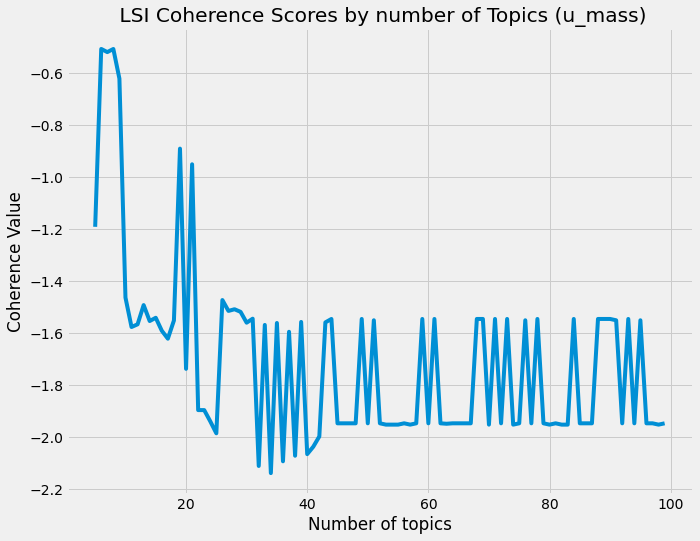

In [24]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lsi, coherence_type='u_mass', algorithm='LSI')

In [25]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass_lsi)

The best number of topics found by u-mass coherence score: 34


It takes long time for calcuating c_v coherence scores, so temporarily disable it. (TODO: Re-enable in final notebook)

In [26]:
# c_v is much slower
#min_topics, max_topics = 5, 100
#coherence_scores_c_v, best_num_topics_c_v = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LSI', coherence_type='c_v')


In [27]:
#plot_coherence_scores(min_topics, max_topics, coherence_scores_c_v, coherence_type='c_v', algorithm='LSI')

In [28]:
#print('The best number of topics found by c-v coherence score:', best_num_topics_c_v)

**Print the topics (based on the best u-mass score):**

In [29]:
lsi_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lsi, algorithm='LSI', num_words=15, friendly_print=True)

Topic 0: ['telepsychology', 'telemental_health', 'service', 'treatment', 'client', 'provide', 'use', 'mental_health', 'care', 'practice', 'patient', 'psychologist', 'technology', 'need', 'include']
Topic 1: ['telepsychology', 'telemental_health', 'psychologist', 'practice', 'client', 'care', 'veteran', 'providers', 'patient', 'mental_health', 'clinic', 'training', 'treatment', 'veterans_affairs', 'veterans_health']
Topic 2: ['telemental_health', 'telepsychology', 'veteran', 'evaluator', 'intervention', 'child', 'treatment', 'clinic', 'videoconferencing', 'service', 'veterans_affairs', 'psychologist', 'evaluation', 'therapy', 'veterans_health']
Topic 3: ['telemental_health', 'psychologist', 'client', 'videoconferencing', 'mental_health', 'treatment', 'information', 'care', 'clinic', 'clinician', 'american_psychological', 'evaluator', 'practice', 'telepsychology', 'telepsychotherapy']
Topic 4: ['telepsychology', 'client', 'clinic', 'trainee', 'psychologist', 'use', 'treatment', 'training

In [30]:
print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lsi, algorithm='LSI', num_words=15, friendly_print=False)

(0, '0.247*"telepsychology" + 0.223*"telemental_health" + 0.213*"service" + 0.188*"treatment" + 0.181*"client" + 0.167*"provide" + 0.157*"use" + 0.156*"mental_health" + 0.155*"care" + 0.145*"practice" + 0.141*"patient" + 0.134*"psychologist" + 0.133*"technology" + 0.129*"need" + 0.127*"include"')
(1, '-0.539*"telepsychology" + 0.494*"telemental_health" + -0.221*"psychologist" + -0.199*"practice" + -0.196*"client" + 0.188*"care" + 0.185*"veteran" + 0.151*"providers" + 0.145*"patient" + 0.103*"mental_health" + -0.097*"clinic" + -0.085*"training" + 0.085*"treatment" + 0.083*"veterans_affairs" + 0.079*"veterans_health"')
(2, '0.328*"telemental_health" + 0.275*"telepsychology" + 0.226*"veteran" + -0.194*"evaluator" + -0.194*"intervention" + -0.187*"child" + -0.181*"treatment" + 0.176*"clinic" + -0.174*"videoconferencing" + 0.152*"service" + 0.151*"veterans_affairs" + 0.144*"psychologist" + -0.133*"evaluation" + -0.132*"therapy" + 0.113*"veterans_health"')
(3, '0.327*"telemental_health" + 0.

**Print the topics (based on the best c-v score):**

In [31]:
#print_topics(dictionary, best_num_topics_c_v, algorithm='LSI', num_words=15, friendly_print=True)

In [32]:
#print_topics(dictionary, best_num_topics_c_v, algorithm='LSI', num_words=15, friendly_print=False)

## Latent Dirichlet Allocation (LDA)

In [33]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lda, best_num_topics_u_mass_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')


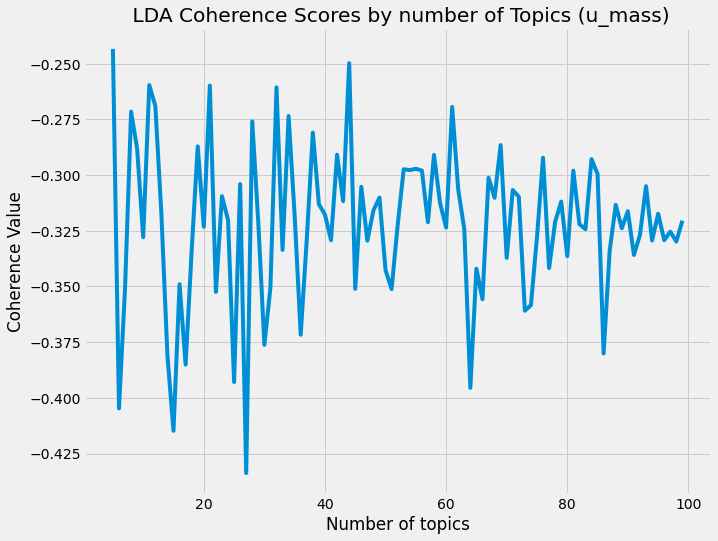

In [34]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda, coherence_type='u_mass', algorithm='LDA')

In [35]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass_lda)

The best number of topics found by u-mass coherence score: 27


In [36]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['telepsychology', 'practice', 'use', 'psychologist', 'service', 'mental_health', 'clinic', 'training', 'treatment', 'technology', 'client', '2020', 'research', 'individual', 'provide']
Topic 1: ['treatment', 'service', 'telepsychology', 'mental_health', 'care', 'need', 'telemental_health', 'training', 'provide', 'practice', 'client', 'intervention', 'use', 'therapy', 'technology']
Topic 2: ['service', 'telepsychology', 'psychologist', 'client', 'mental_health', 'patient', 'care', 'health', 'telemental_health', 'treatment', 'provide', 'practice', 'therapy', 'veteran', 'technology']
Topic 3: ['care', 'mental_health', 'patient', 'telemental_health', 'treatment', 'use', 'health', 'need', 'service', 'include', 'veteran', 'technology', 'provide', 'telepsychology', '2020']
Topic 4: ['therapy', 'treatment', 'parent–child_interaction', 'provide', 'care', 'telepsychology', 'child', 'telemental_health', 'technology', 'family', 'clinic_base', 'condition', 'use', 'session', 'therapist']
T

In [37]:
print_topics(dictionary, bow_corpus, best_num_topics_u_mass_lda, algorithm='LDA', num_words=15, friendly_print=False)

(0, '0.012*"therapy" + 0.011*"telemental_health" + 0.010*"client" + 0.007*"service" + 0.006*"psychologist" + 0.005*"american_psychological" + 0.005*"program" + 0.005*"provide" + 0.005*"2013" + 0.005*"datum" + 0.005*"training" + 0.005*"2015" + 0.004*"practice" + 0.004*"telepsychology" + 0.004*"include"')
(1, '0.012*"service" + 0.010*"telemental_health" + 0.009*"psychologist" + 0.009*"client" + 0.007*"providers" + 0.007*"mental_health" + 0.006*"record" + 0.006*"practice" + 0.006*"provide" + 0.006*"information" + 0.006*"therapy" + 0.006*"access" + 0.006*"american_psychological" + 0.005*"datum" + 0.005*"program"')
(2, '0.008*"treatment" + 0.007*"mental_health" + 0.006*"service" + 0.006*"therapy" + 0.006*"provide" + 0.005*"studies_analysis" + 0.005*"need" + 0.005*"include" + 0.005*"patient" + 0.005*"care" + 0.005*"health" + 0.005*"veteran" + 0.005*"use" + 0.004*"child" + 0.004*"telepsychology"')
(3, '0.011*"telepsychology" + 0.010*"client" + 0.009*"mental_health" + 0.009*"care" + 0.008*"pra

**LDA model perplexity score**

In [38]:
perplexity = lda_model.log_perplexity(bow_corpus)

print('LDA model Perplexity:', perplexity)

LDA model Perplexity: -8.917849745398131


**Find the dominant topic in each article**

Notes: ldamodel[corpus] invokes __ getitem __(), which returns a list of (int, float) Topic distribution for the given document. Each topic is represented as a pair of its ID and the probability assigned to it.

In [39]:
debug=False

In [40]:
def identify_dominant_topic(ldamodel=lda_model, corpus=bow_corpus, texts=text_corpus):
  
  doc_topics_df = pd.DataFrame()

  for artical_index, topic_dist in enumerate(lda_model[bow_corpus]): 
    
    if(debug):
      print(artical_index, topic_dist)
    
    row = sorted(topic_dist, key=lambda x: (x[1]), reverse=True)
    
    if(debug):
      print(row)

    # Get the Dominant topic, Percentage Contribution and Keywords for each document
    for j, (topic_num, topic_percentage_contribution) in enumerate(row):
      if j == 0:  # => dominant topic
        term_wt = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([term for term, wt in term_wt])
        doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(topic_percentage_contribution,4), topic_keywords]), ignore_index=True)
      else:
        break

  doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

  # Add original text to the end of the output
  contents = pd.Series(texts)
  doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    
  return doc_topics_df

In [41]:
df_topic_keywords = identify_dominant_topic(ldamodel=lda_model, corpus=bow_corpus, texts=text_corpus)

df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percentage_Contrib', 'Topic_Keywords', 'Text']


In [42]:
pd.set_option('display.max_colwidth', 100)

In [43]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Percentage_Contrib,Topic_Keywords,Text
0,0,22.0,0.6872,"client, service, telepsychology, provide, treatment, practice, technology, need, therapy, psycho...",veteran face variety stressor relate military service Institute Medicine 2014 Tanielian 2008 ve...
1,1,10.0,0.2757,"training, treatment, telemental_health, intervention, skill, client, online, need, practice, vid...",impact coronavirus disease 2019 pandemic child custody evaluation child custody evaluation commu...
2,2,0.0,0.9979,"telepsychology, practice, use, psychologist, service, mental_health, clinic, training, treatment...",November 2019 coronavirus disease 2019 infectious highly communicable potentially fatal disease ...
3,3,0.0,0.5113,"telepsychology, practice, use, psychologist, service, mental_health, clinic, training, treatment...",anxiety depressive disorder common impair mental illness United States World Health Organization...
4,4,18.0,0.9997,"participant, client, clinician, telepsychology, family, intervention, online, work, session, cha...",mid March 2020 author majority therapist advise work home office help stop spread Covid-19 Covid...
5,5,0.0,0.9755,"telepsychology, practice, use, psychologist, service, mental_health, clinic, training, treatment...",early January 2020 chinese health authority notify World Health Organization new type coronaviru...
6,6,9.0,0.9492,"telepsychology, psychologist, practice, use, concern, training, client, participant, 2020, provide",million people diagnosable mental disorder United States adequate access train mental health pro...
7,7,26.0,0.9689,"mental_health, telemental_health, service, treatment, health, client, provide, need, care, use",primary focus coronavirus disease 2019 impact physical health pandemic multidimensional multisys...
8,8,18.0,0.9995,"participant, client, clinician, telepsychology, family, intervention, online, work, session, cha...",worldwide gap mental health need child adolescent receive treatment Kieling Baker Henningham Bel...
9,9,21.0,0.9073,"telemental_health, veteran, care, service, treatment, patient, mental_health, providers, veteran...",time write introduction coronavirus disease 2019 infect million kill hundred thousand expect mul...


In [44]:
df_dominant_topic.to_csv('./Data/Dominant_Topic_of_Article_LDA.csv')

**Visualize the topics-keywords using pyLDAvis**

**Notes: Colab doesn't support the latest pyLDAvis currently due to conflicts among packages, so installing older version of pyLDAvis seems to be a walk-around solution.**

In [45]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6MB 6.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=3a263ad951e1f67b5a75de4d42eddf7bd6ef5f770238759d503f09e83caff0cb
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [46]:
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()

In [47]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
22    -0.019410  0.012413       1        1  28.515237
21    -0.026591 -0.062950       2        1  20.602306
0     -0.059506  0.046497       3        1  14.293806
18     0.057619  0.063055       4        1   7.042173
26    -0.021077 -0.001735       5        1   6.921873
10     0.039558  0.006609       6        1   4.942844
24     0.007587 -0.015340       7        1   4.233902
19     0.029514 -0.021743       8        1   3.717830
14    -0.017729 -0.012628       9        1   2.399672
9     -0.036535  0.043990      10        1   2.387601
25    -0.026464  0.007859      11        1   1.795144
4      0.015686 -0.008682      12        1   1.678324
11    -0.002376  0.017518      13        1   0.831861
15     0.035142 -0.009243      14        1   0.618607
6     -0.007733 -0.003839      15        1   0.001448
1     -0.002307  0.002427      16        1   0.001448
2      0.000150 -0.001344      17        1   0.001448
3     -0.001188 -0.012711      18        1   0.001448
5      0.014365  0.008912      19        1   0.001448
23    -0.000239 -0.015111      20        1   0.001448
7      0.012487  0.002178      21        1   0.001448
8     -0.000980 -0.014153      22        1   0.001448
20    -0.000019 -0.010324      23        1   0.001448
12     0.000040 -0.021607      24        1   0.001448
16     0.000260  0.003612      25        1   0.001448
17    -0.003788 -0.005326      26        1   0.001448
13     0.013534  0.001667      27        1   0.001448, topic_info=                  Term        Freq       Total Category  logprob  loglift
439            service  833.000000  833.000000  Default  30.0000  30.0000
502  telemental_health  787.000000  787.000000  Default  29.0000  29.0000
504     telepsychology  973.000000  973.000000  Default  28.0000  28.0000
520          treatment  827.000000  827.000000  Default  27.0000  27.0000
300      mental_health  685.000000  685.000000  Default  26.0000  26.0000
..                 ...         ...         ...      ...      ...      ...
322               need    0.004976  554.072378  Topic27  -5.8021  -0.4774
382          providers    0.004169  385.934805  Topic27  -5.9792  -0.2928
502  telemental_health    0.004760  787.704648  Topic27  -5.8466  -0.8737
439            service    0.004751  833.138975  Topic27  -5.8485  -0.9317
835           clinical    0.004070  373.837538  Topic27  -6.0033  -0.2851

[2115 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
8754       1  0.316174        0001
8754       7  0.474260        0001
4027       6  0.270944         001
4027      10  0.270944         001
6379       1  0.757794         1lt
...      ...       ...         ...
3050       3  0.101911        zoom
3050       4  0.458600        zoom
3050       6  0.050956        zoom
3050      11  0.050956        zoom
10176     12  0.600774  βcondition

[4083 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 22, 1, 19, 27, 11, 25, 20, 15, 10, 26, 5, 12, 16, 7, 2, 3, 4, 6, 24, 8, 9, 21, 13, 17, 18, 14])

## Non-Negative Matrix Factorization (NMF)

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

**Function that use NMF to build topic model and print topics:**

In [49]:
def print_NMF_topics(tokenized_texts, max_df=0.95, min_df=1, number_topics=20, number_words_per_topic=10):
  
  text_list=[]

  for token_array in tokenized_texts:
    text_list.append(" ".join(token_array))  # concat tokens for each document to make compatible format for vectorizer.fit_transform()

  vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
  X = vectorizer.fit_transform(text_list)

  idx_to_word = np.array(vectorizer.get_feature_names())

  # apply NMF
  nmf = NMF(n_components=number_topics, solver="mu")
  W = nmf.fit_transform(X)  # document_topics
  H = nmf.components_       # topic_terms

  for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word [topic.argsort()[-number_words_per_topic:]]])))

**Print topics modeled by NMF for all artices:**

In [50]:
print_NMF_topics(tokenized_texts)

Topic 1: trauma,2020,pandemic,disorder,disease,2019,stress,posttraumatic,coronavirus,telepsychotherapy
Topic 2: interjurisdictional,psychology,american,psychological,association,state,client,practice,psychologist,telepsychology
Topic 3: service,healthcare,care,york,harbor,affairs,telemental,hub,veteran,veterans
Topic 4: bit,providers,couple,service,online,technologies,module,client,intervention,telemental
Topic 5: randomized,meta,clinician,veteran,deliver,studies,face,intervention,analysis,telepsychology
Topic 6: director,transition,supervision,student,telepsychology,supervisor,telesupervision,training,clinic,trainee
Topic 7: score,caregiver,posttreatment,tutorial,behavior,skill,therapy,interaction,child,parent
Topic 8: television,book,user,guide,internet,patient,borgueta,self,help,guided
Topic 9: family,model,integrate,primary,community,disparity,brazil,rural,care,latinx
Topic 10: kbit,taker,index,examinee,proctor,subtest,remote,wisc,test,administration
Topic 11: datum,correctional,in

## Pre-Covid Topic Modeling 

In [51]:
df_precovid = df_overview[df_overview["Classification"] == "Pre-Covid"]

In [52]:
df_precovid.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Stopwords_Lemma_Longform_Clean_Content,Clean_Content,Classification
20,Rehabilitation Psychology,Clinician Perspectives Delivering Telehealth Interventions to Children/Families Impacted by Pedi...,2019,Shari L. Wade; Stacey P. Raj; Emily L. Moscato; Megan E. Narad,Purpose: Technological advances have made the delivery of psychological interventions via web-ba...,"KEYWORDS:\r\n\r\nclinicians, pediatric traumatic brain injury, telepsychology","Wade, S. L., Raj, S. P., Moscato, E. L., & Narad, M. E. (2019). Clinician perspectives deliverin...",IntroductionTraumatic brain injury (TBI) represents the leading cause of death and disability in...,36695,2526,"['clinicians,', 'pediatric', 'traumatic', 'brain', 'injury,', 'telepsychology']",6,Health Psychology & Medicine,29,"introductiontraumatic brain injury TBI represent lead cause death disability childhood 600,000 c...","introductiontraumatic brain injury TBI represent lead cause death disability childhood 600,000 c...",Pre-Covid
21,Psychological Services,"Efficacy of Synchronous Telepsychology Interventions for People With Anxiety, Depression, Posttr...",2019,Tracey Varker; Rachel M. Brand; Janine Ward; Sonia Terhaag; Andrea Phelps,Telepsychology holds promise as a treatment delivery method that may increase access to services...,"KEYWORDS:\r\n\r\ntelepsychology, Internet delivered text based, telephone delivered, video-telec...","Varker, T., Brand, R. M., Ward, J., Terhaag, S., & Phelps, A. (2019). Efficacy of synchronous te...",The use of information and communication technologies has emerged as the next big frontier in th...,32051,1382,"['telepsychology,', 'Internet', 'delivered', 'text', 'based,', 'telephone', 'delivered,', 'video...",9,Clinical & Counseling Psychology,83,use information communication technology emerge big frontier efficient effective delivery health...,use information communication technology emerge big frontier efficient effective delivery health...,Pre-Covid
22,Translational Issues in Psychological Science,The Role of Telepsychology Training Clinics in Addressing Health Disparities With Rural Latinx I...,2019,Meredith A. Martyr; D. Martin Kivlighan III; Saba Rasheed Ali,"Hispanic individuals comprise the largest immigrant group in the United States, consisting of 55...","KEYWORDS: immigration, Latinx, health disparities, telepsychology, integrated behavioral health","Martyr, M. A., Kivlighan, D. M. III, & Ali, S. R. (2019). The role of telepsychology training cl...","Health disparities across the nation are on the rise, most notably among Latinx and Hispanic imm...",22867,1749,"['immigration,', 'Latinx,', 'health', 'disparities,', 'telepsychology,', 'integrated', 'behavior...",8,General Psychology,31,health disparity nation rise notably Latinx hispanic immigrant population example high mortality...,health disparity nation rise notably Latinx hispanic immigrant population example high mortality...,Pre-Covid
23,Clinical Psychology: Science and Practice,Integrating technological advances into clinical training and practice: The future is now!,2018,Jeffrey E. Barnett,NaN,"KEYWORDS:\r\n\r\nboundaries, competence, ethics, technology, telepsychology, training","Barnett, J. E. (2018). Integrating technological advances into clinical training and practice: T...","The use of various technologies, such as videoconferencing, email, text messaging, apps, and soc...",18682,3,"['boundaries,', 'competence,', 'ethics,', 'technology,', 'telepsychology,', 'training']",6,Clinical & Counseling Psychology,0,use technology videoconferencing email text messaging app social medium nearly ubiquitous societ...,use technology videoconferencing email text messaging app social medium nearly ubiquitous societ...,Pre-Covid
24,Clinical Psychology: Science and Practice,Navigating the ethics of Internet-guided self-hel

**Retrieve Pre-Covid text corpus:**

In [53]:
text_corpus_precovid = df_precovid[TEXT_COLUMN_NAME].values

**Build dictionary, bow, and tokenized texts from Pre-Covid corpus:**

In [54]:
dictionary_precovid, bow_corpus_precovid, tokenized_texts_precovid = build_dictionary_preprocess_corpus(text_corpus_precovid)


**Use LSI topic model to print topics of Pre-Covid articles:**

In [55]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lsi_precovid, best_num_topics_u_mass_lsi_precovid = generate_coherence_scores(min_topics, max_topics, tokenized_texts_precovid, bow_corpus_precovid, dictionary_precovid, algorithm='LSI', coherence_type='u_mass')


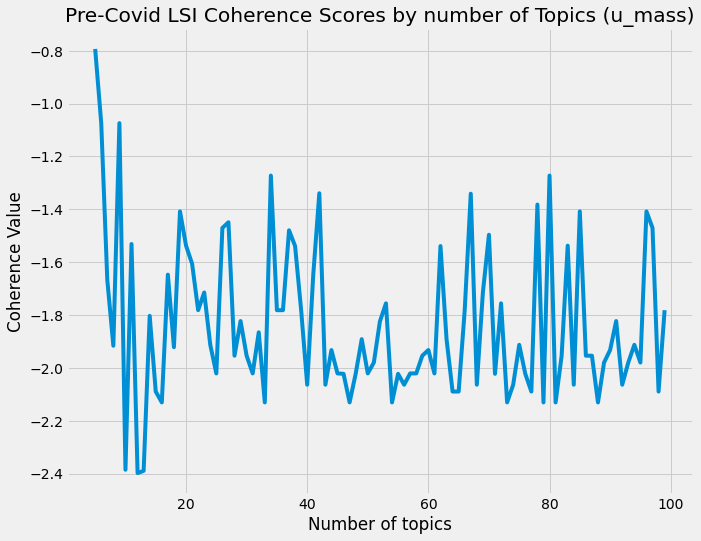

In [56]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lsi_precovid, coherence_type='u_mass', algorithm='LSI', legend='Pre-Covid')


In [57]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass_lsi_precovid)


The best number of topics found by u-mass coherence score: 12


In [58]:
lsi_model_precovid = print_topics(dictionary_precovid, bow_corpus_precovid, best_num_topics_u_mass_lsi_precovid, algorithm='LSI', num_words=15, friendly_print=True)


Topic 0: ['telemental_health', 'service', 'treatment', 'intervention', 'care', 'provide', 'mental_health', 'therapy', 'program', 'veteran', 'technology', 'client', 'include', 'need', 'self_help']
Topic 1: ['veteran', 'self_help', 'internet_guided', 'telemental_health', 'veterans_affairs', 'user', 'intervention', 'service', 'clinic', 'care', 'patient', 'community', 'client', 'guide', 'program']
Topic 2: ['telemental_health', 'therapy', 'psychologist', 'intervention', 'american_psychological', 'clinician', 'client', 'family', 'care', 'agency', 'treatment', 'practice', 'mental_health', 'information', 'national_security']
Topic 3: ['self_help', 'internet_guided', 'user', 'intervention', 'family', 'program', 'telepsychology', 'guide', 'treatment', 'clinician', 'therapy', 'service', 'veteran', 'care', 'patient']
Topic 4: ['telesupervision', 'trainee', 'supervision', 'supervisor', 'provide', 'veteran', 'training', 'service', 'rotation', 'person', 'telemental_health', 'experience', 'clinical_v

**Use LDA topic model to print topics of Pre-Covid articles:**

In [59]:
min_topics, max_topics = 1, 100
coherence_scores_u_mass_lda_precovid, best_num_topics_u_mass_lda_precovid = generate_coherence_scores(min_topics, max_topics, tokenized_texts_precovid, bow_corpus_precovid, dictionary_precovid, algorithm='LDA', coherence_type='u_mass')


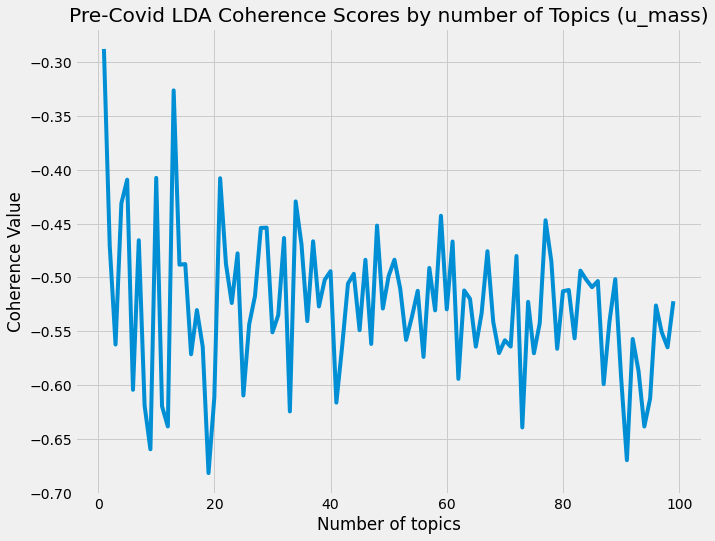

In [60]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda_precovid, coherence_type='u_mass', algorithm='LDA', legend='Pre-Covid')

In [61]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass_lda_precovid)

The best number of topics found by u-mass coherence score: 19


In [62]:
lda_model_precovid = print_topics(dictionary_precovid, bow_corpus_precovid, best_num_topics_u_mass_lda_precovid, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['telemental_health', 'program', 'therapy', 'psychologist', 'client', 'provide', 'mental_health', 'service', 'self_help', 'intervention', 'user', 'american_psychological', 'treatment', 'use', 'information']
Topic 1: ['telesupervision', 'trainee', 'supervision', 'provide', 'care', 'supervisor', 'training', 'telemental_health', 'need', 'experience', 'technology', 'include', 'person', 'rotation', 'clinical_video']
Topic 2: ['service', 'treatment', 'care', 'telepsychology', 'technology', 'intervention', 'mental_health', 'provide', 'self_help', 'telemental_health', 'program', 'internet_guided', 'psychologist', 'need', 'client']
Topic 3: ['intervention', 'treatment', 'family', 'mental_health', 'telemental_health', 'clinician', 'care', 'technology', 'telepsychology', 'need', 'service', 'provide', 'user', 'include', 'client']
Topic 4: ['telemental_health', 'service', 'care', 'treatment', 'provide', 'mental_health', 'patient', 'therapy', 'intervention', 'program', 'include', 'client', 

**Use NMF topic model to print topics of Pre-Covid articles:**

In [63]:
print_NMF_topics(tokenized_texts_precovid, number_words_per_topic=10)

Topic 1: staff,service,healthcare,affairs,harbor,hub,york,veteran,telemental,veterans
Topic 2: association,psychology,technology,lustgarten,2018,elhai,telepractice,telepsychology,psychologist,practice
Topic 3: interaction,income,role,complete,care,report,need,child,parent,family
Topic 4: providers,medical,brazil,primary,model,rural,disparity,community,mental,care
Topic 5: need,clinical,social,competence,psychotherapist,technology,online,medium,practice,client
Topic 6: community,tows,clinic,shore,tribal,care,affairs,indian,veterans,veteran
Topic 7: professional,person,client,relationship,important,american,evidence,need,policy,individual
Topic 8: colleague,book,issue,ethical,guide,intervention,self,borgueta,patient,help
Topic 9: clinical,guide,bit,technologies,base,couple,client,user,technology,intervention
Topic 10: automate,content,comer,family,behavioral,telemental,bit,intervention,couple,technologies
Topic 11: community,mental,telepsychology,integrate,immigrant,behavioral,rural,disp

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


## Topic Modeling for articles posted during Covid 

In [64]:
df_covid = df_overview[df_overview["Classification"] == "Covid"]

In [65]:
df_covid.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Stopwords_Lemma_Longform_Clean_Content,Clean_Content,Classification
0,Psychological Services,The Effectiveness of Telepsychology With Veterans: A Meta-Analysis of Services Delivered by Vide...,2021,Michael J. McClellan; Richard Osbaldiston; Rongxiu Wu; Rachael Yeager; Addison D. Monroe; Tyler ...,Veterans face a variety of stressors due to their military service and are more likely to develo...,"KEYWORDS:\r\n\r\ntelepsychology, meta-analysis, veteran, videoconference, phone","McClellan, M. J., Osbaldiston, R., Wu, R., Yeager, R., Monroe, A. D., McQueen, T., & Dunlap, M. ...","Veterans face a variety of stressors related to their military service (Institute of Medicine, 2...",37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran,', 'videoconference,', 'phone']",5,Clinical & Counseling Psychology,50,veteran face variety stressor relate military service Institute Medicine 2014 Tanielian et al 20...,veteran face variety stressor relate military service Institute Medicine 2014 Tanielian 2008 ve...,Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remote Child Custody Evaluations (RCCES): The Empirica...,2021,Milfred D. Dale; Desiree Smith,"The COVID-19 pandemic and its requirements for social distancing and limited, if any, in-person ...","KEYWORDS:\r\n\r\nremote child custody evaluations, videoconferencing, telemental health, ethics ...","Dale, M. D., & Smith, D. (2021). Making the case for videoconferencing and remote child custody ...",The impact of the COVID-19 pandemic on the child custody evaluation (CCE) community has been ast...,74025,1577,"['remote', 'child', 'custody', 'evaluations,', 'videoconferencing,', 'telemental', 'health,', 'e...",10,Forensic Psychology,48,impact coronavirus disease 2019 pandemic child custody evaluation child custody evaluation commu...,impact coronavirus disease 2019 pandemic child custody evaluation child custody evaluation commu...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Priorities, and Policy Directions",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychology that is relatively underdeveloped considering ...,"KEYWORDS:\r\n\r\nforensic e-mental health, telehealth, telepsychology, forensic evaluation, corr...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Forensic e-mental health: Review, research prioritie...","In November 2019, COVID-19—the infectious, highly communicable, and potentially fatal disease ca...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealth,', 'telepsychology,', 'forensic', 'evaluation,',...",8,Forensic Psychology,128,November 2019 coronavirus disease 2019 infectious highly communicable potentially fatal disease ...,November 2019 coronavirus disease 2019 infectious highly communicable potentially fatal disease ...,Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in University Training Clinics: Considerations and Cur...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing numerous challenges resulting from the COVID-19 pand...,"KEYWORDS:\r\n\r\neducation and training, telepsychology, COVID-19, pandemic","Baier, A. L., & Danzo, S. (2021). Moving toward a new era of telepsychology in university traini...",Anxiety and depressive disorders are among the most common and impairing mental illnesses in the...,30147,1650,"['education', 'and', 'training,', 'telepsychology,', 'COVID-19,', 'pandemic']",6,Clinical & Counseling Psychology,21,anxiety depressive disorder common impair mental illness United States World Health Organization...,anxiety depressive disorder common impair mental illness United States World Health Organization...,Covid
4,Practice Innovations,Navigating Changes in the Physica

**Retrieve text corpus of articles posted during Covid:**

In [66]:
text_corpus_covid = df_covid[TEXT_COLUMN_NAME].values

**Build dictionary, bow, and tokenized texts from corpus of articles posted during Covid:**

In [67]:
dictionary_covid, bow_corpus_covid, tokenized_texts_covid = build_dictionary_preprocess_corpus(text_corpus_covid)


**Use LSI topic model to print topics of articles posted during Covid:**

In [68]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass_lsi_covid, best_num_topics_u_mass_lsi_covid = generate_coherence_scores(min_topics, max_topics, tokenized_texts_covid, bow_corpus_covid, dictionary_covid, algorithm='LSI', coherence_type='u_mass')


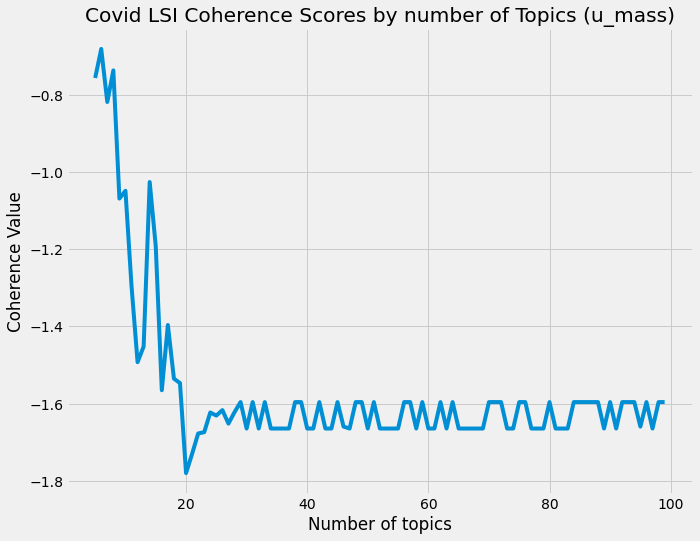

In [69]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lsi_covid, coherence_type='u_mass', algorithm='LSI', legend='Covid')


In [70]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass_lsi_covid)


The best number of topics found by u-mass coherence score: 20


In [71]:
lsi_model_covid = print_topics(dictionary_covid, bow_corpus_covid, best_num_topics_u_mass_lsi_covid, algorithm='LSI', num_words=15, friendly_print=True)


Topic 0: ['telepsychology', 'client', 'service', 'telemental_health', 'treatment', 'provide', 'practice', 'use', 'patient', 'care', 'mental_health', 'psychologist', 'need', 'technology', 'include']
Topic 1: ['telemental_health', 'telepsychology', 'client', 'psychologist', 'care', 'patient', 'practice', 'providers', 'clinic', 'trainee', 'veteran', 'mental_health', 'training', 'studies_analysis', 'treatment']
Topic 2: ['telemental_health', 'evaluator', 'videoconferencing', 'telepsychology', 'evaluation', 'child', 'care', 'clinic', 'providers', 'interview', 'veteran', 'forensic', 'veterans_health', 'forensic_mental', 'child_custody']
Topic 3: ['telemental_health', 'videoconferencing', 'mental_health', 'psychologist', 'telepsychotherapy', 'treatment', 'disorder', 'evaluator', '2019', 'posttraumatic_stress', '2020', 'telepsychology', 'health', 'coronavirus_disease', 'intervention']
Topic 4: ['psychologist', 'clinic', 'client', 'telepsychology', 'trainee', 'practice', 'treatment', 'training'

**Use LDA topic model to print topics of articles posted during Covid:**

In [72]:
min_topics, max_topics = 1, 100
coherence_scores_u_mass_lda_covid, best_num_topics_u_mass_lda_covid = generate_coherence_scores(min_topics, max_topics, tokenized_texts_covid, bow_corpus_covid, dictionary_covid, algorithm='LDA', coherence_type='u_mass')


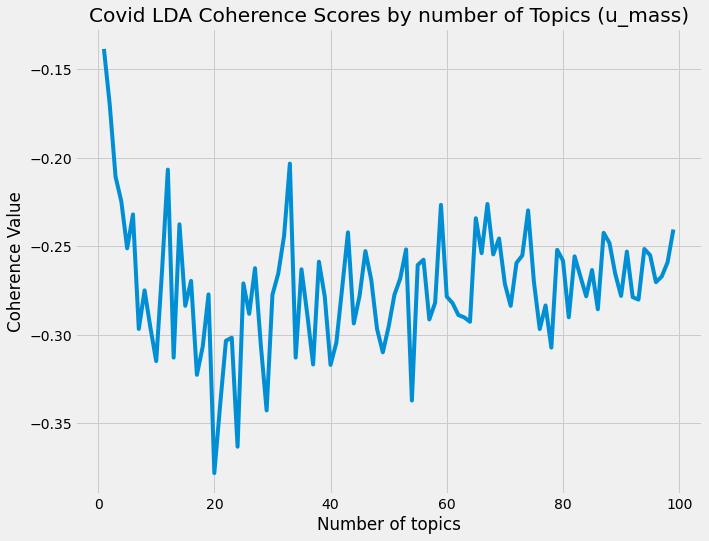

In [73]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_lda_covid, coherence_type='u_mass', algorithm='LDA', legend='Covid')

In [74]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass_lda_covid)

The best number of topics found by u-mass coherence score: 20


In [75]:
lda_model_covid = print_topics(dictionary_covid, bow_corpus_covid, best_num_topics_u_mass_lda_covid, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['service', 'client', 'telepsychology', 'telemental_health', 'practice', 'provide', 'use', 'patient', 'mental_health', 'treatment', '2019', 'include', 'psychologist', 'technology', 'care']
Topic 1: ['training', 'skill', 'behavioral_parent', 'participant', 'rating', 'online_tutorial', 'time', 'provide', 'child', 'practice', 'telepsychology', 'knowledge', 'study', 'increase', 'fidelity_implementation']
Topic 2: ['psychologist', 'telepsychology', 'client', 'telemental_health', 'service', 'practice', 'patient', 'treatment', 'providers', 'provide', 'participant', 'use', '2019', 'need', 'technology']
Topic 3: ['administration', 'care', 'veterans_health', 'service', 'telemental_health', 'need', 'use', 'provide', 'mental_health', 'video', '2020', 'client', 'test', 'telehealth', '2019']
Topic 4: ['2020', 'care', '2019', 'technology', 'hilty', 'clinical', '2018', 'need', 'health', '2017', 'competency', 'child_adolescent', 'asynchronous', 'base', 'training']
Topic 5: ['record', 'client',

**Use NMF topic model to print topics of articles posted during Covid:**

In [76]:
print_NMF_topics(tokenized_texts_covid, number_words_per_topic=10)

Topic 1: 2020,care,disorder,pandemic,telepsychotherapy,posttraumatic,2019,stress,disease,coronavirus
Topic 2: psychology,association,concern,affairs,service,participant,state,client,psychologist,telepsychology
Topic 3: https,measure,feedback,care,clinician,based,client,measurement,telemental,mbc
Topic 4: provider,increase,service,analysis,studies,attitude,patient,care,providers,telemental
Topic 5: research,datum,interview,court,child,videoconferencing,evaluation,custody,evaluator,forensic
Topic 6: online,fidelity,praise,rating,participant,behavioral,tutorial,parent,skill,training
Topic 7: stimulus,score,online,kbit,format,remote,index,subtest,administration,wisc
Topic 8: workshop,encourage,service,director,student,training,supervisor,trainee,telepsychology,clinic
Topic 9: educational,licensure,telepractice,service,state,interstate,profession,professional,compact,tbh
Topic 10: service,social,telehealth,loneliness,informal,caregiver,disease,chronic,respiratory,lower
Topic 11: psychopatho

Reference Notes:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

"Text Analytics with Python_ A Practitioner's Guide to Natural Language Processing, 2nd ed"